<a href="https://colab.research.google.com/github/AbdullahBarayan/DENGUE-FEVER-PREDICTION/blob/main/DENGUE_FEVER_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install numpy pandas scikit-learn tensorflow gradio matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, Model
import gradio as gr

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
DATA_PATH = "/content/dengue_final_dataset.csv"  # upload this to Colab

df = pd.read_csv(DATA_PATH)

# Keep only DengAI cities
df = df[df["City"].isin(["sj", "iq"])].copy()

# Clean types
df["Year"] = pd.to_numeric(df["Year"], errors="coerce").astype(int)
df["WeekOfYear"] = pd.to_numeric(df["WeekOfYear"], errors="coerce").astype(int)
for c in ["Temperature_C","Humidity","Precipitation_mm","DengueCases"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna().reset_index(drop=True)

# Sort correctly (real chronology)
df = df.sort_values(["City","Year","WeekOfYear"]).reset_index(drop=True)

print("Filtered DengAI shape:", df.shape)
df.head()

Filtered DengAI shape: (1443, 7)


,City,Year,WeekOfYear,Temperature_C,Humidity,Precipitation_mm,DengueCases
0,iq,2000,26,23.590000,92.418571,25.41,0
1,iq,2000,27,23.484286,93.581429,60.61,0
2,iq,2000,28,23.265714,95.848571,55.52,0
3,iq,2000,29,22.207143,87.234286,5.60,0
4,iq,2000,30,23.282857,88.161429,62.76,0


In [3]:
# Seasonality encoding (important)
df["woy_sin"] = np.sin(2*np.pi*df["WeekOfYear"]/52.0)
df["woy_cos"] = np.cos(2*np.pi*df["WeekOfYear"]/52.0)

# Lag features
TARGET_LAGS = [1,2,3,4]
ENV_LAGS = [1,2,3,4,5,6]

df2 = df.copy()

for lag in TARGET_LAGS:
    df2[f"cases_lag_{lag}"] = df2.groupby("City")["DengueCases"].shift(lag)

for lag in ENV_LAGS:
    df2[f"temp_lag_{lag}"] = df2.groupby("City")["Temperature_C"].shift(lag)
    df2[f"hum_lag_{lag}"]  = df2.groupby("City")["Humidity"].shift(lag)
    df2[f"rain_lag_{lag}"] = df2.groupby("City")["Precipitation_mm"].shift(lag)

# Rolling means (boost accuracy)
for win in [3,6]:
    df2[f"cases_roll_{win}"] = df2.groupby("City")["DengueCases"].rolling(win).mean().reset_index(level=0, drop=True)
    df2[f"temp_roll_{win}"]  = df2.groupby("City")["Temperature_C"].rolling(win).mean().reset_index(level=0, drop=True)
    df2[f"rain_roll_{win}"]  = df2.groupby("City")["Precipitation_mm"].rolling(win).mean().reset_index(level=0, drop=True)

df2 = df2.dropna().reset_index(drop=True)
df2_sorted = df2.sort_values(["City","Year","WeekOfYear"]).reset_index(drop=True)

print("After features:", df2.shape)

After features: (1431, 37)


In [4]:
LOOKBACK = 16
HORIZON  = 1

FEATURE_COLS = (
    ["Temperature_C","Humidity","Precipitation_mm","woy_sin","woy_cos"]
    + [c for c in df2.columns if "lag_" in c or "roll_" in c]
)

TARGET_COL = "DengueCases"

def make_sequences(g):
    g = g.sort_values(["Year","WeekOfYear"]).reset_index(drop=True)
    X = g[FEATURE_COLS].values.astype(np.float32)
    y = g[TARGET_COL].values.astype(np.float32)

    Xs, ys = [], []
    for i in range(LOOKBACK, len(g)-HORIZON+1):
        Xs.append(X[i-LOOKBACK:i])
        ys.append(y[i+HORIZON-1])
    return np.array(Xs), np.array(ys)

def split_time(X, y, test=0.15, val=0.15):
    n = len(X)
    n_test = max(1, int(n*test))
    n_val  = max(1, int(n*val))
    Xtr, ytr = X[:-(n_test+n_val)], y[:-(n_test+n_val)]
    Xva, yva = X[-(n_test+n_val):-n_test], y[-(n_test+n_val):-n_test]
    Xte, yte = X[-n_test:], y[-n_test:]
    return Xtr,ytr,Xva,yva,Xte,yte

# Stack city sequences but split inside each city (no leakage)
Xtr_list, ytr_list = [], []
Xva_list, yva_list = [], []
Xte_list, yte_list = [], []
city_tag_te = []

for city in ["sj","iq"]:
    g = df2_sorted[df2_sorted["City"] == city].copy()
    X, y = make_sequences(g)

    y_log = np.log1p(y)

    Xtr,ytr,Xva,yva,Xte,yte = split_time(X, y_log)

    Xtr_list.append(Xtr); ytr_list.append(ytr)
    Xva_list.append(Xva); yva_list.append(yva)
    Xte_list.append(Xte); yte_list.append(yte)

    city_tag_te += [city]*len(Xte)

Xtr = np.concatenate(Xtr_list); ytr = np.concatenate(ytr_list)
Xva = np.concatenate(Xva_list); yva = np.concatenate(yva_list)
Xte = np.concatenate(Xte_list); yte = np.concatenate(yte_list)
city_tag_te = np.array(city_tag_te)

print("Train/Val/Test:", Xtr.shape, Xva.shape, Xte.shape)

Train/Val/Test: (981, 16, 33) (209, 16, 33) (209, 16, 33)


In [5]:
scaler = MinMaxScaler()
scaler.fit(Xtr.reshape(-1, Xtr.shape[-1]))

def scale_seq(A):
    return scaler.transform(A.reshape(-1, A.shape[-1])).reshape(A.shape)

Xtr_s = scale_seq(Xtr)
Xva_s = scale_seq(Xva)
Xte_s = scale_seq(Xte)

In [6]:
def build_model(kind, n_features):
    seq = layers.Input(shape=(LOOKBACK, n_features))
    x = seq

    if kind == "LSTM":
        x = layers.LSTM(128, return_sequences=True)(x)
        x = layers.Dropout(0.25)(x)
        x = layers.LSTM(64)(x)

    elif kind == "BiLSTM":
        x = layers.Bidirectional(layers.LSTM(96, return_sequences=True))(x)
        x = layers.Dropout(0.25)(x)
        x = layers.Bidirectional(layers.LSTM(64))(x)

    elif kind == "CNN-LSTM":
        x = layers.Conv1D(96, 3, padding="causal", activation="relu")(x)
        x = layers.MaxPool1D(2)(x)
        x = layers.LSTM(96)(x)

    else:
        raise ValueError("Unknown model")

    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(1)(x)

    m = Model(seq, out)
    m.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3, clipnorm=1.0),
        loss=tf.keras.losses.Huber()
    )
    return m

def train_eval(kind):
    m = build_model(kind, Xtr_s.shape[-1])
    cb = [
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.5, min_lr=1e-5),
    ]
    hist = m.fit(Xtr_s, ytr, validation_data=(Xva_s, yva),
                 epochs=120, batch_size=32, verbose=1, callbacks=cb)

    pred_log = m.predict(Xte_s, verbose=0).reshape(-1)
    pred = np.expm1(pred_log)
    y_true = np.expm1(yte)

    rmse = np.sqrt(mean_squared_error(y_true, pred))
    mae  = mean_absolute_error(y_true, pred)
    r2   = r2_score(y_true, pred)

    return m, hist, pred, y_true, rmse, mae, r2

models, histories, preds = {}, {}, {}
rows = []

for kind in ["LSTM","BiLSTM","CNN-LSTM"]:
    m, hist, pred, y_true, rmse, mae, r2 = train_eval(kind)
    models[kind] = m
    histories[kind] = hist
    preds[kind] = pred
    rows.append([kind, rmse, mae, r2])

results_df = pd.DataFrame(rows, columns=["Model","RMSE","MAE","R2"]).sort_values("RMSE")
print(results_df)

# pick best model
best_kind = results_df.iloc[0]["Model"]
best_model = models[best_kind]
print("Best model:", best_kind)

Epoch 1/120
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - loss: 1.1816 - val_loss: 0.4360 - learning_rate: 0.0010
Epoch 2/120
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.5811 - val_loss: 0.4676 - learning_rate: 0.0010
Epoch 3/120
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.4165 - val_loss: 0.3455 - learning_rate: 0.0010
Epoch 4/120
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.3415 - val_loss: 0.3009 - learning_rate: 0.0010
Epoch 5/120
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.3396 - val_loss: 0.3021 - learning_rate: 0.0010
Epoch 6/120
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.2737 - val_loss: 0.3088 - learning_rate: 0.0010
Epoch 7/120
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.2794 - val_loss: 0.2929 - learning_rate: 0.0010
Epoch 8/120
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.2652 - val_loss: 0.2485 - learning_rate: 0.0010
Epoch 9/120
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.3130 - val_loss: 0.2812 - learning_rate: 0.0010
Epoch 10

      Model       RMSE       MAE        R2
1    BiLSTM  13.543155  7.746392  0.700941
2  CNN-LSTM  19.099120  9.456142  0.405236
0      LSTM  20.387233  9.839984  0.322305
Best model: BiLSTM


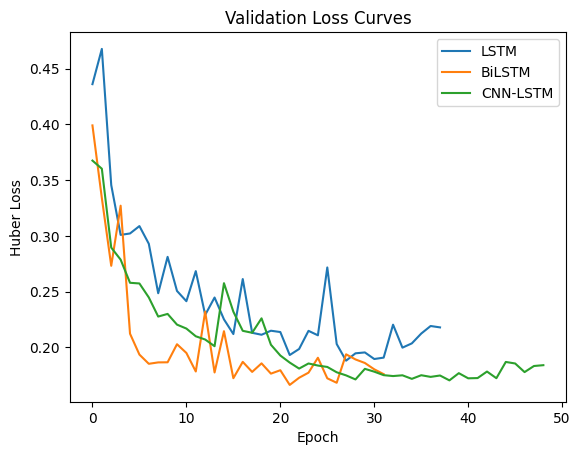

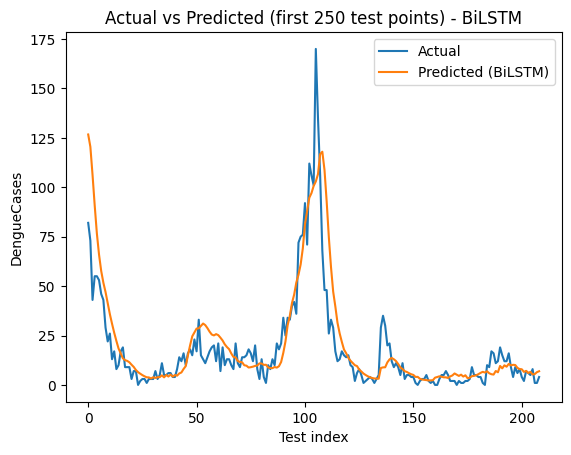

sj -> RMSE: 16.25, R2: 0.680
iq -> RMSE: 6.01, R2: 0.287


In [7]:
# Validation loss curves
plt.figure()
for kind, hist in histories.items():
    plt.plot(hist.history["val_loss"], label=f"{kind}")
plt.title("Validation Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Huber Loss")
plt.legend()
plt.show()

# Best model plot
best_pred = preds[best_kind]
y_true = np.expm1(yte)

plt.figure()
plt.plot(y_true[:250], label="Actual")
plt.plot(best_pred[:250], label=f"Predicted ({best_kind})")
plt.title(f"Actual vs Predicted (first 250 test points) - {best_kind}")
plt.xlabel("Test index")
plt.ylabel("DengueCases")
plt.legend()
plt.show()

# Per-city performance
for city in ["sj","iq"]:
    mask = (city_tag_te == city)
    rmse_city = np.sqrt(mean_squared_error(y_true[mask], best_pred[mask]))
    r2_city = r2_score(y_true[mask], best_pred[mask])
    print(f"{city} -> RMSE: {rmse_city:.2f}, R2: {r2_city:.3f}")

In [8]:
import gradio as gr
import numpy as np
import pandas as pd

# =========================
# RISK ENGINE (temp/hum/prec ONLY)
# =========================
# Simple, explainable heuristic:
# - Mosquito/dengue risk rises with warm temp, high humidity, and rainfall/stagnant water.
# - We normalize each to 0..1 then compute weighted sum.
# - Output: Low / Medium / High
#
# You can tune thresholds later, but this will NOT always show low.

TEMP_MIN, TEMP_MAX = 10.0, 40.0
HUM_MIN, HUM_MAX   = 30.0, 100.0
PREC_MIN, PREC_MAX = 0.0, 500.0

def clamp01(x):
    return max(0.0, min(1.0, x))

def norm(x, lo, hi):
    return clamp01((x - lo) / (hi - lo))

def risk_from_climate(temp_c, humidity, precip_mm):
    # Normalize
    t = norm(temp_c, TEMP_MIN, TEMP_MAX)
    h = norm(humidity, HUM_MIN, HUM_MAX)
    p = norm(precip_mm, PREC_MIN, PREC_MAX)

    # Weighted risk score (0..1)
    # Temp matters most, then humidity, then precipitation
    score = 0.45*t + 0.35*h + 0.20*p

    if score >= 0.70:
        level = "🔴 High Risk"
        msg = "Conditions strongly favor mosquito activity. Take precautions and monitor local alerts."
    elif score >= 0.45:
        level = "🟠 Medium Risk"
        msg = "Conditions may support mosquito activity. Reduce exposure and remove standing water."
    else:
        level = "🟢 Low Risk"
        msg = "Conditions are less favorable right now, but still stay aware of local updates."

    return score, level, msg

# =========================
# SINGLE CHECK (no city)
# =========================
def single_check(temp_c, humidity, precip_mm):
    score, level, msg = risk_from_climate(temp_c, humidity, precip_mm)

    out = (
        f"Risk Assessment: {level}\n"
        f"Risk Score: {score:.2f} (0 to 1)\n\n"
        f"{msg}"
    )

    details = (
        f"**Input Climate Conditions**\n"
        f"- 🌡️ Temperature: {temp_c:.1f} °C\n"
        f"- 💧 Humidity: {humidity:.1f} %\n"
        f"- 🌧️ Precipitation: {precip_mm:.1f} mm\n"
    )
    return out, details

# =========================
# BATCH CHECK (CSV upload)
# =========================
# Supports ANY cities in your file.
# Required: Temperature_C, Humidity, Precipitation_mm
# Optional: City column (will be kept in output if present)
def batch_check(file):
    if file is None:
        return "Upload a CSV first.", None

    dfb = pd.read_csv(file.name)

    needed = ["Temperature_C", "Humidity", "Precipitation_mm"]
    missing = [c for c in needed if c not in dfb.columns]
    if missing:
        return f"CSV missing columns: {missing}\nRequired columns: {needed}", None

    scores, levels, notes = [], [], []
    for _, row in dfb.iterrows():
        score, level, msg = risk_from_climate(
            float(row["Temperature_C"]),
            float(row["Humidity"]),
            float(row["Precipitation_mm"])
        )
        scores.append(round(score, 3))
        levels.append(level.replace("🔴 ", "").replace("🟠 ", "").replace("🟢 ", ""))
        notes.append(msg)

    out = dfb.copy()
    out["RiskScore"] = scores
    out["RiskLevel"] = levels
    out["RiskNote"]  = notes

    out_path = "batch_risk_results.csv"
    out.to_csv(out_path, index=False)
    return "Batch risk check completed. Download the output below.", out_path

# =========================
# OPTIONAL: MODEL INFO (FYP)
# =========================
# If you have these variables from training, it will show them:
# best_kind, LOOKBACK, FEATURE_COLS, best_model, results_df
def make_model_info_text():
    try:
        best_row = results_df.sort_values("RMSE").iloc[0]
        rmse = float(best_row["RMSE"])
        mae  = float(best_row["MAE"])
        r2   = float(best_row["R2"])
        return (
            f"**Forecasting Model:** {best_kind}\n\n"
            f"**Input Shape:** ({LOOKBACK}, {len(FEATURE_COLS)})\n\n"
            f"**Features:** {len(FEATURE_COLS)}\n\n"
            f"**Parameters:** {best_model.count_params():,}\n\n"
            f"---\n"
            f"**Performance**\n\n"
            f"- RMSE: {rmse:.2f}\n"
            f"- MAE: {mae:.2f}\n"
            f"- R²: {r2:.4f}\n"
        )
    except:
        return (
            "**Forecasting Model info not available in this runtime.**\n\n"
            "Run the training section first if you want RMSE/MAE/R² shown here."
        )

CUSTOM_CSS = """
:root { color-scheme: dark; }
.gradio-container { background: #070B14 !important; }
h1,h2,h3,p,li,label,span,div { color: #E8EEF9 !important; }
#titlebar {
  padding: 18px 22px;
  background: radial-gradient(1200px 700px at 20% 0%, rgba(98, 76, 255, 0.25), transparent),
              radial-gradient(900px 500px at 70% 10%, rgba(0, 163, 255, 0.18), transparent);
  border: 1px solid rgba(255,255,255,0.08);
  border-radius: 16px;
}
.card {
  background: rgba(255,255,255,0.04);
  border: 1px solid rgba(255,255,255,0.08);
  border-radius: 16px;
  padding: 16px;
}
.bigbox textarea {
  font-size: 18px !important;
  line-height: 1.35 !important;
  min-height: 180px !important;
}
"""

with gr.Blocks(css=CUSTOM_CSS, title="Dengue Risk Checker + Forecast System") as demo:
    gr.HTML("""
    <div id="titlebar">
      <div style="font-size:34px; font-weight:800;">🦟 Dengue Fever Prediction</div>
      <div style="font-size:18px; font-weight:650; margin-top:4px;">Climate-based risk (Temperature / Humidity / Precipitation)</div>
      <div style="opacity:0.85; margin-top:6px;">Single check + batch CSV check. (Forecast model info is in a separate tab.)</div>
    </div>
    """)

    with gr.Tabs():
        with gr.TabItem("🎯 Single Risk Check"):
            gr.Markdown("Set climate meters and get a **Low / Medium / High** dengue risk estimate.")
            with gr.Row():
                with gr.Column(scale=1):
                    temp_slider = gr.Slider(TEMP_MIN, TEMP_MAX, value=27, step=0.1, label="🌡️ Temperature (°C)")
                    hum_slider  = gr.Slider(HUM_MIN, HUM_MAX, value=75, step=0.1, label="💧 Relative Humidity (%)")
                    prec_slider = gr.Slider(PREC_MIN, PREC_MAX, value=50, step=0.5, label="🌧️ Precipitation (mm)")
                    check_btn = gr.Button("✅ Check Dengue Risk", variant="primary")

                with gr.Column(scale=1):
                    out = gr.Textbox(label="Risk Output", elem_classes=["bigbox"])
                    details = gr.Markdown()

            check_btn.click(single_check, inputs=[temp_slider, hum_slider, prec_slider], outputs=[out, details])

        with gr.TabItem("📊 Batch Risk Check (CSV)"):
            gr.Markdown("Upload a CSV with **Temperature_C, Humidity, Precipitation_mm**. Optional **City** column is supported.")
            batch_file = gr.File(label="Upload CSV", file_types=[".csv"])
            run_btn = gr.Button("Run Batch Risk Check", variant="primary")
            status = gr.Textbox(label="Status", lines=2)
            out_file = gr.File(label="Download Results CSV")

            run_btn.click(batch_check, inputs=[batch_file], outputs=[status, out_file])

        with gr.TabItem("ℹ️ Forecast Model Information (FYP)"):
            gr.Markdown("This tab is for your FYP forecasting model.")
            model_info = gr.Markdown(make_model_info_text())

        with gr.TabItem("📌 Info"):
            gr.HTML("""
            <div class="card">
              <h2 style="margin:0 0 10px 0;">How to Test</h2>
              <ol style="line-height:1.8;">
                <li>Go to <b>Single Risk Check</b>.</li>
                <li>Adjust the meters and click <b>Check Dengue Risk</b>.</li>
                <li>Go to <b>Batch Risk Check</b> and upload a CSV to evaluate multiple cities/rows at once.</li>
              </ol>
            </div>
            <div class="card" style="margin-top:14px;">
              <h2 style="margin:0 0 10px 0;">What this means</h2>
              <ul style="line-height:1.8;">
                <li>This risk checker uses only climate conditions (Temperature/Humidity/Precipitation).</li>
                <li>It does <b>not</b> guarantee dengue cases in your exact city; it estimates environmental suitability.</li>
              </ul>
            </div>
            """)

demo.launch(share=True)

/tmp/ipython-input-1337804177.py:156: DeprecationWarning: The 'css' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'css' to Blocks.launch() instead.
  with gr.Blocks(css=CUSTOM_CSS, title="Dengue Risk Checker + Forecast System") as demo:


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://45238c724ff4a93587.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
